In [1]:
import ugradio
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import dish
import cartopy.crs as ccrs
from scipy.interpolate import interp2d
from tqdm import tqdm, trange
%matplotlib inline

No module named 'rtlsdr'


In [2]:
def calibrate(data_nd0, data_nd1, pol):
    diff = np.array(data_nd1) - np.array(data_nd0)
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
    G = T/diff
    t_line = G * data_nd0
    return t_line

def calibrate1(data_nd0, data_nd1, pol):
    diff = np.median(np.array(data_nd1) - np.array(data_nd0))
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
    G = T/diff
    t_line = G * data_nd0
    return t_line

def calibrate2(data_nd0, data_nd1, pol):
    
    F_low = 146.5
    F_high = 148.5
    freq = np.linspace(144,156,8192)
    condition = (freq >= F_low) * (freq <= F_high)
    trunc_freq = freq[condition]
    
    diff = np.median(np.array(data_nd1[:,condition]) - np.array(data_nd0[:,condition]))
    
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
        
    G = T/diff
    t_line = G * data_nd0
    return t_line

In [3]:
nfiles = 697
nfreq = 8192

In [4]:
nspec = 50

list_0 = np.empty((nfiles, nspec, nfreq))
# list_1 = np.empty((nfiles, nspec, nfreq))

for i in trange(nfiles):
    
    f = fits.open(f'lab4_data/{i}_nd0.fits')
    
    for j in range(nspec):
        
        list_0[i,j] = f[j+1].data['auto0_real']
        
#         list_1[i,j] = f[j+1].data['auto1_real']

100%|██████████| 697/697 [02:36<00:00,  4.45it/s]


In [5]:
noise_spec = 5

noise_0 = np.empty((nfiles, noise_spec, nfreq))
# noise_1 = np.empty((nfiles, noise_spec, nfreq))

for i in trange(nfiles):
    
    f = fits.open(f'lab4_data/{i}_nd1.fits')
    
    for j in range(noise_spec):
        
        noise_0[i,j] = f[j+1].data['auto0_real']
        
#         noise_1[i,j] = f[j+1].data['auto1_real']

100%|██████████| 697/697 [00:18<00:00, 37.18it/s]


In [6]:
median_specs_0 = np.median(list_0, axis=1)
# median_specs_1 = np.median(list_1, axis=1)

In [7]:
median_noise_0 = np.median(noise_0, axis=1)
# median_noise_1 = np.median(noise_1, axis=1)

In [8]:
Tline_0 = calibrate2(median_specs_0, median_noise_0, 0)
# Tline_1 = calibrate2(median_specs_1, median_noise_1, 1)

In [73]:
F_low = 149.7
F_high = 150.2
freq = np.linspace(144,156,8192)
condition = (freq >= F_low) * (freq <= F_high)

ctline_0 = np.empty((nfiles, nfreq))
# ctline_1 = np.empty((nfiles, nfreq))

for i in trange(nfiles):
    sub_0 = Tline_0[i] - np.median(Tline_0[i,condition])
    ctline_0[i] = sub_0
#     sub_1 = Tline_1[i] - np.median(Tline_1[i,condition])
#     ctline_1[i] = sub_1

100%|██████████| 697/697 [00:00<00:00, 6417.29it/s]


In [77]:
trunc_freq = freq[condition]
trunc_spec = ctline_0[120, condition]

gaussian_fit, cov = ugradio.gauss.gaussfit(x = trunc_freq, y = trunc_spec,
                                          amp = trunc_spec.max(),
                                          avg = 149.9,
                                          sig = 0.3,
                                          return_cov = True)
gaussian_fit

{'amp': array([20.60510886]),
 'avg': array([149.92074041]),
 'sig': array([0.04346557])}

In [78]:
gaussian_val = ugradio.gauss.gaussval(trunc_freq, 
                                     gaussian_fit['amp'],
                                     gaussian_fit['avg'],
                                     gaussian_fit['sig'])

<function matplotlib.pyplot.show(*args, **kw)>

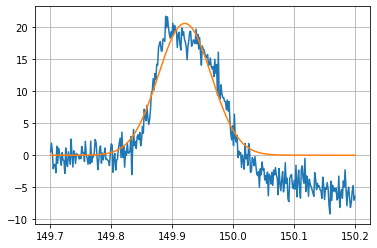

In [79]:
plt.plot(trunc_freq,trunc_spec)
plt.plot(trunc_freq, gaussian_val)
plt.grid()
plt.show